# TODO  
## Write C functions (tv_denoise, tv_denoise_core, tv_denoise_core_org)  
## Understand the difference between tv_denoise_core, tv_denoise_core_org  
## Add legends to the pics
## ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
# import visvis as vv
%matplotlib inline

In [2]:
import multiprocessing as mp
from time import sleep

In [41]:
import workers

# Some funcs from tools.c that we use (done)

# TVdenoise main part in Matlab is done but C function has to be written!!

In [4]:
image = cv2.imread('Pirate.tif', 0)

In [61]:
def create_noisy_image(image, noise_std):
    noisy_image = image + np.random.normal(scale=noise_std, size=image.shape)
    return np.clip(noisy_image, 0, 255)

In [62]:
def plot_image(image):
    plt.figure(figsize = (10, 10))
    plt.imshow(image, cmap = 'gray')

In [69]:
noisy_image = create_noisy_image(image, 25)

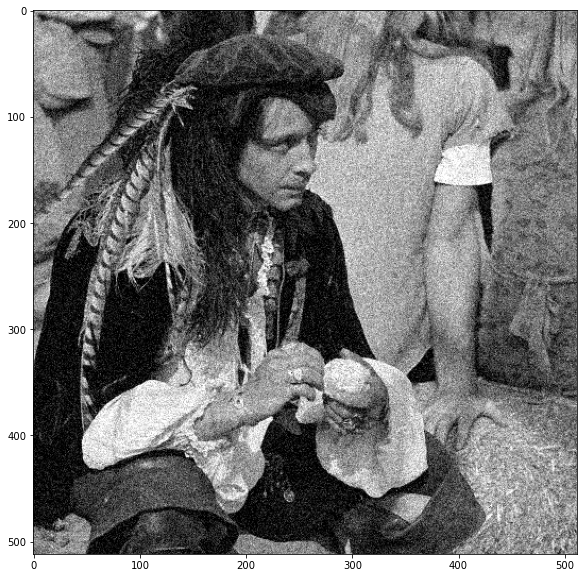

In [71]:
plot_image(noisy_image)

In [72]:
def TVdenoise_demo(image_path, noise_std, tau):
    
    image = cv2.imread(image_path, 0)
    
    noisy_image = create_noisy_image(image, noise_std)
    
    plot_image(image)
    plot_image(noisy_image)
    
    height = noisy_image.shape[0]
    width = noisy_image.shape[1]
    
    delta = tau * np.sqrt(height * width) * noise_std
    
    denoised_image, res = TVdenoise(noisy_image, delta, noise_std, tau)
    
    denoised_image = denoised_image.reshape((height, width)) # do M x N
    
    plot_image(denoised_image)
    return denoised_image, res

In [129]:
def TVdenoise(noisy_image, delta, sigma, tau, eps_rel = 10e-3):

    alpha = np.sum(noisy_image.flatten()) / len(noisy_image)
    X = alpha * np.ones(noisy_image.shape)
    mdelta = np.linalg.norm(X - noisy_image, 'fro')
    if mdelta < delta:
        #maybe put some info here like in paper
        return
    elif mdelta < 1.1 * delta:
        #maybe throw warning like in paper
        print('Convergence problems may arise')
    
    R = noisy_image.max()
    mn = noisy_image.shape[0] * noisy_image.shape[1]
    epsilon = R * mn * eps_rel
    mu = epsilon / mn
    Lmu = 8 / mu
    N = ((4 * np.sqrt(2) * tau * sigma) / (eps_rel * R)).astype(int) # maxiter as far as I understood
    N *= 10
    X, res = tv_denoise_core_org_parallel(noisy_image, delta, epsilon, Lmu, mu, N) # rewrite C func!!!!
    return X, res

In [134]:
def tv_denoise_core_org_parallel(noisy_image, delta, eps, L, mu, maxiter): 
        
        pobj = 0
        dobj = 0
        res_l = []
        m = noisy_image.shape[0]
        n = noisy_image.shape[1]
        mn = m * n
        mL = -L
        A_kp1 = 0.5
        noisy_image = noisy_image.flatten()
        wk = np.zeros(mn)
        x = noisy_image.copy()
        uij = np.zeros(2)
        
        for k in range(maxiter):
            print(f'{k} iteration')
            pobj = 0
            df = np.zeros(mn)
            # step1
            for j in range(n - 1):
                for i in range(m - 1):
                    i1 = (i + 1) + j * m
                    i2 = i + (j + 1) * m
                    i3 = i + j * m
                    uij[0] = x[i1] - x[i3]
                    uij[1] = x[i2] - x[i3]
                    
                    c1 = np.sqrt(uij[0] * uij[0] + uij[1] * uij[1])
                    pobj += c1
                    
                    c2 = max(mu, c1)
                    uij[0] = uij[0] / c2
                    uij[1] = uij[1] / c2
                    
                    df[i1] += uij[0]
                    df[i3] -= uij[0]
                    df[i2] += uij[1]
                    df[i3] -= uij[1]
                    
            dobj = df.dot(noisy_image) - delta * np.linalg.norm(df)
            res = pobj - dobj
            print(res)
            res_l.append(res)
            if res < eps:
                break
                
            with mp.Pool(2) as pool:
                results = [pool.apply_async(workers.y_count, (L, x, noisy_image, df, delta)),
                           pool.apply_async(workers.z_count, (wk, k, df, L, delta, noisy_image))]
                y_k = results[0].get()
                wk, zk = results[1].get()
        #step4
            x = ((2 /(k + 3)) * zk) + (((k + 1)/(k + 3)) * y_k)
        return x, res_l

0 iteration
11112458.25266268
1 iteration
11112458.25266268
2 iteration
11214251.50135869
3 iteration
11416383.335774744
4 iteration
11718812.822458463
5 iteration
12123610.035293752
6 iteration
12628465.160880497
7 iteration
13225710.957845058
8 iteration
13914495.956487166
9 iteration
14698359.339564694
10 iteration
15579304.362102386
11 iteration
16534390.652812319
12 iteration
17254890.354628645
13 iteration
17805369.743889265
14 iteration
18228907.4570088
15 iteration
18555474.41362267
16 iteration
18806572.28938827
17 iteration
18997974.19367633
18 iteration
19141501.91732284
19 iteration
19246152.360431958
20 iteration
19318880.511396736
21 iteration
19365133.463887632
22 iteration
19389248.12485469
23 iteration
19394694.956559688
24 iteration
19384287.493950427
25 iteration
19360323.590034496
26 iteration
19324696.69944822
27 iteration
19278978.8404444
28 iteration
19224484.87078488
29 iteration
19162322.185719952
30 iteration
19093428.16114327
31 iteration
19018601.94039543
32

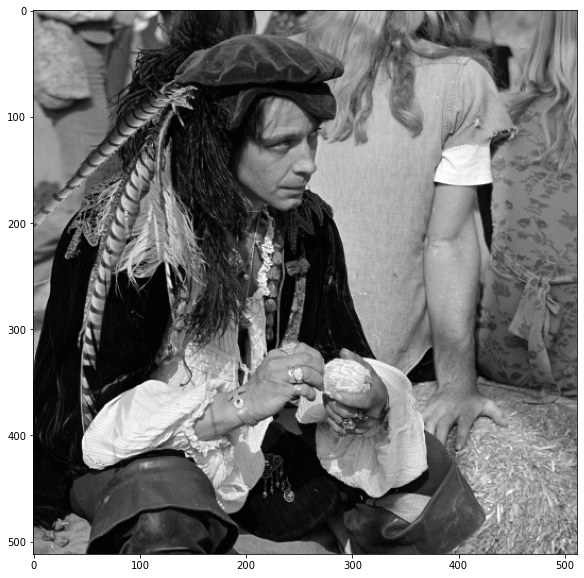

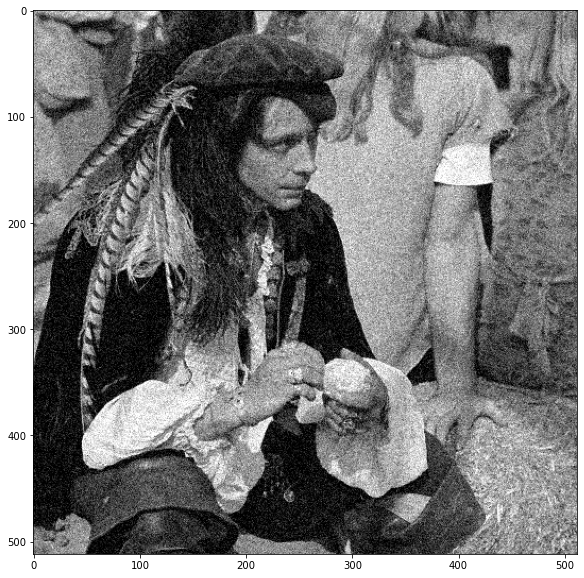

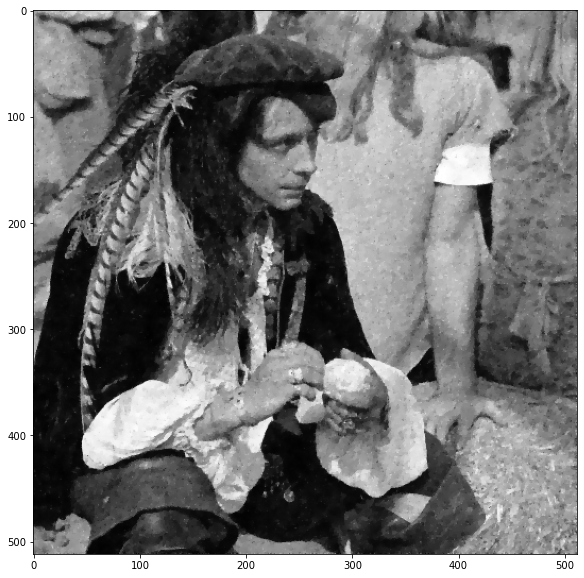

In [135]:
denoised_image, res = TVdenoise_demo('Pirate.tif', 25, 0.85) # add legends to  pictures!!!

In [136]:
res

[11112458.25266268,
 11112458.25266268,
 11214251.50135869,
 11416383.335774744,
 11718812.822458463,
 12123610.035293752,
 12628465.160880497,
 13225710.957845058,
 13914495.956487166,
 14698359.339564694,
 15579304.362102386,
 16534390.652812319,
 17254890.354628645,
 17805369.743889265,
 18228907.4570088,
 18555474.41362267,
 18806572.28938827,
 18997974.19367633,
 19141501.91732284,
 19246152.360431958,
 19318880.511396736,
 19365133.463887632,
 19389248.12485469,
 19394694.956559688,
 19384287.493950427,
 19360323.590034496,
 19324696.69944822,
 19278978.8404444,
 19224484.87078488,
 19162322.185719952,
 19093428.16114327,
 19018601.94039543,
 18938528.206812255,
 18853795.597860508,
 18764912.72864225,
 18672323.50067122,
 18576413.88083491,
 18477521.905436285,
 18375944.74692194,
 18271944.58768241,
 18165753.526590556,
 18057577.696765542,
 17947600.736721866,
 17835986.728807338,
 17722882.696684852,
 17608420.7361929,
 17492719.84004421,
 17375887.46584159,
 17258020.8880053

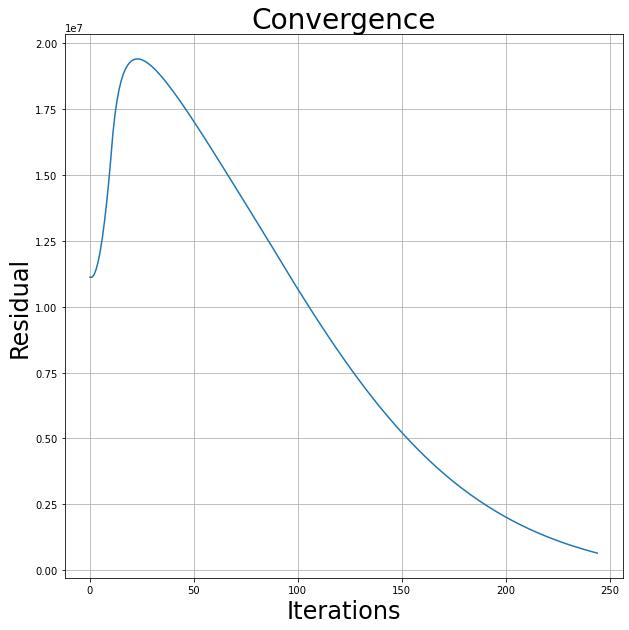

In [144]:
plt.figure(figsize=(10, 10))
plt.plot(res)
plt.grid(True)
plt.xlabel('Iterations', size=24)
plt.ylabel('Residual', size=24)
plt.title('Convergence', size=28);

# TVdenoise_demo matlab script from paper (done)

# tv_denoise.c  более менее переписана, но подумать о том, как возвращать значения

# tv_denoise_core_org.c